# Assignment 2: The Winter is here
##### This works best with epic battle music. No spoilers present.
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tywin Lannister was right when he said: "The great war is between death and life, ice and fire. If we loose, the night will never end"<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It has been six months since the white walkers' army marched into the north, led by the night king himself on a dead dragon. It has been a battle like never before: never before have men faced such an enemy in battle, never before have men fought so bravely against a united threat, and never before have they been so gravely defeated.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While Cersei is in King's landing, brave men have died fighting the great war. Among others, Tyrion is dead, Arya is dead and Jon Snow is dead, again. In a desperate battle, Daenerys leads all her forces in a final stand-off with the dead just south of Winterfell. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Her army defeated, she is now on the run on her dragon in an air battle, being chased by two of her own dragons, the Night king and a dead Jon Snow. Suddenly, the Night king's spear hits Danny's dragon, who, raining blood and fire, falls into ice, taking the lost queen, with him. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Daenerys opens her eyes in a strange place, a place which does not follow the rules of space and time, where the dead souls killed by the dead men are trapped, forever. But who woke her up? There stands near her, Tyrion, with Jorah, Davos, Jon Snow, and everybody else. They all indulge in a heartfelt reunion when someone yells- "But how do we get out?<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Varys sees a talking crystal close by, who asks them of completing a task, which on completion would allow them to go back to the land of the living, with the ultimate tool to defeat the white-walkers and kills the night king, the Dragon-axe. They have summoned you for help, as the task is out of their expertise, to apply a modified CNN to solve the object detection problem on the PASCAL VOC dataset. Varys, the master of whisperers, has used his talents to import the following for you:

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# You can ask Varys to get you more if you desire
import xml.etree.ElementTree as ET
import glob
import PIL.Image
import PIL.ImageChops
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import skimage.measure
import skimage.morphology
from random import randint

resnet_input = 224#size of resnet18 input images

In [2]:
# Cersei chose violence, you choose your hyper-parameters wisely using validation data!
batch_size = 100
num_epochs = 5
learning_rate =  0.01
hyp_momentum = 0.9

## Build the data
The hound who was in charge for getting the data, brought you the following links:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>He also told you that the dataset(datascrolls :P) consists of images from of 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can ask Varys to import xml.etree.ElementTree for you. <br/>
<br/> You can then ask Bronn and Jamie to organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [3]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
# Taken form pyimagesearch for calculating intersection over union
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea + np.finfo(float).eps)
 
    # return the intersection over union value
    return iou

In [5]:
# Taken from stackoverflow for drawing random bounding boxes
def random_bbox(bbox):
    v = [randint(0, v) for v in bbox]
    left = min(v[0], v[2])
    upper = min(v[1], v[3])
    right = max(v[0], v[2])
    lower = max(v[1], v[3])
    return [left, upper, right, lower]

In [50]:
def jamie_bronn_build_dataset(dir,img_path):            
    image = PIL.Image.open(img_path)
    img_name = img_path.split("/")[-1].split(".")[-2]
    print(img_name)
    xml_path = dir+'/Annotations/'+img_name+'.xml'
    xml_tree = ET.parse(xml_path)
    xml_root = xml_tree.getroot()

#     temp_img = PIL.Image.new('RGB',image.size,0)
#     image.show()
    
    location = []
    labels = []
    object_img = []
    img_names = []
    for object in xml_root.findall('object'):
        name = object.find('name').text
        position = [int(object.find('bndbox').find('xmin').text), int(object.find('bndbox').find('ymin').text),
                    int(object.find('bndbox').find('xmax').text), int(object.find('bndbox').find('ymax').text)]
        location.append(position)
        crop_img = image.crop(position).convert('RGB')
        object_img.append(crop_img)
        labels.append(classes.index(name))
        img_names.append(int(img_name))
        
#         temp_img.paste(crop_img,position)

#     temp_img = PIL.ImageChops.subtract(image,temp_img)
#     l = skimage.morphology.label(np.array(image.convert('L')))
#     regions = skimage.measure.regionprops(l)
#     max_area = 0
#     for region in regions:
#         if region.area >= max_area:
#             position = region.bbox
#             max_area = region.area
            
#     location.append(position)        
#     crop_img = image.crop(position).convert('RGB')
# #     crop_img.show()
#     object_img.append(crop_img)
#     labels.append(classes.index('__background__'))

    iou_threshold = 0.3
    num = 0
    while(num < 1):
        bbox = image.getbbox()
        boxA = random_bbox(bbox)
        mscore = 0
        for boxB in location:
                score = (bb_intersection_over_union(boxA, boxB))
                if (score > mscore):
                    mscore = score
        if (mscore < iou_threshold):
            object_img.append(image.crop(boxA).convert('RGB'))
            labels.append(classes.index('__background__'))
            img_names.append(int(img_name))
            num = num + 1
        
    return object_img, labels, img_names

In [62]:
class hound_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        print(train)
        if(train):
            dir = root_dir + '/train/VOCdevkit/VOC2007'
        else :
            dir = root_dir + '/test/VOCdevkit/VOC2007'
        self.transform = transform
        self.train = train
        self.img = [];
        self.label = [];
        self.img_names = []
        i = 0
        for img_path in glob.glob(dir+'/JPEGImages/*.jpg'):
            object_img, name, img_name = jamie_bronn_build_dataset(dir,img_path)
            self.img.extend(object_img)
            self.label.extend(name)
            self.img_names.extend(img_name)
#             i = i+1
#             if i == 7:
#                 break
                       
                
    def __len__(self):
        return len(self.img)
        
    def __getitem__(self, idx):
        if self.transform is None:
            return (transforms_Tensor(self.img[idx]),self.label[idx],self.img_names[idx])
        else:
            img_transformed = self.transform(self.img[idx])
            return (img_transformed,self.label[idx],self.img_names[idx])

In [63]:
# train_dataset = hound_dataset(root_dir='.', train=False, transform=None) # Supply proper root_dir

## Train the netwok
<br/>You can ask Arya to train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [64]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])
train_dataset = hound_dataset(root_dir='.', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = hound_dataset(root_dir='.', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

False
003341
003843
003400
008566
009127
003437
009956
009506
004559
005924
003217
009505
002602
006905
005479
004497
003591
001694
007186
004036
004207
002753
006052
005886
007674
007393
000333
004099
009109
002780
006322
004381
000881
008379
007693
005342
006885
001474
007891
001671
009132
000553
009752
008861
008481
000272
005025
007499
005106
009770
000409
001095
002028
000204
008089
003595
001019
004276
001748
002123
007778
002122
002861
006478
009265
003819
008778
006452
009612
004516
000678
002195
008289
002639
008569
008118
009344
007981
008511
009799
004400
008539
004130
005157
006457
001114
006441
001048
001587
005100
001374
002726
008431
005154
008570
004730
000319
002577
008266
000585
006149
001163
007112
002326
009103
000873
008972
002612
008746
007027
003725
004696
002818
006008
008334
008257
004525
009765
003095
008077
000952
000604
008270
002651
008383
005462
002210
009662
001567
006741
006996
005973
003388
007782
009890
005775
006651
005437
004388
008286
009391
006977


000453
007858
005216
005043
003151
006798
001283
004243
001391
000059
008902
009861
002189
000734
007316
004007
008378
000393
009581
001635
006491
005537
004427
008938
003012
004320
009483
005247
000252
002313
006832
008743
004602
004358
007802
000884
006102
008303
002133
004249
005733
001099
006014
008178
004578
007808
001356
009555
004580
000292
005776
007307
007542
007617
005435
003076
008619
007403
005105
008808
006514
004335
007118
002327
006815
004175
003718
006946
008447
009257
003055
002679
003687
003238
002301
002981
000398
001394
005800
005463
008287
005113
002991
009142
008071
006653
004399
000315
004698
006601
002830
009110
005372
005797
004398
005643
001100
005649
001005
000692
002809
009820
005846
007595
006785
007076
000300
002930
001120
001025
003736
003275
001525
007137
000985
002316
006311
003383
005692
000538
002553
008761
001253
009256
003480
009824
007235
008565
008014
006716
006623
008015
009569
009660
000098
009088
002289
000536
004420
003951
002292
007952
004523

004394
000789
003328
007747
006302
007862
008156
003268
006692
005915
003312
006080
007273
001674
007553
008246
006364
009423
007290
002560
003789
006728
003999
006469
001447
008803
009235
006907
004048
004811
001883
009253
000784
006265
002720
001602
008583
008448
008179
008183
001377
002223
001267
002430
000573
004914
003071
002309
002694
001659
005237
005545
003315
006504
001884
006957
007828
002185
005140
005712
004925
003612
009199
009023
005793
001181
008827
002517
008614
002746
000788
001419
008577
000287
007616
008110
004688
003745
009030
005862
001530
006118
001994
008660
003641
000283
008545
004449
004334
009137
002948
001303
000260
009149
004835
003091
006720
009353
002754
007502
007539
007714
002396
005480
002217
004383
009340
006213
001363
002275
004277
001506
002728
001473
000747
001946
006094
009119
009266
009241
009689
003920
005048
009040
006809
001347
008899
002511
001044
002426
000766
008245
000932
004461
001641
009188
008540
009111
007764
003036
002890
000913
000357

009847
007978
003323
006257
005727
008904
007441
000670
004403
003132
000607
006010
003888
004139
008807
008863
005916
003929
003235
000785
003739
007287
002162
004942
007936
004188
003557
005376
002996
006711
005324
001814
006106
000969
004489
003952
003179
005933
008231
003805
003964
004418
002141
001811
004757
003456
008661
006115
006787
008131
000092
002538
001712
005000
007794
009564
003035
006510
009665
005265
000640
005849
003540
009578
003378
008050
000659
004844
007951
000696
001615
007848
001566
006691
009076
009626
009492
000534
008846
009720
001817
004889
003583
002463
004988
001098
009056
007990
000673
008196
009633
000988
007110
001038
002446
007866
005076
004348
002607
004728
009062
009314
007880
009607
005622
007320
008736
000809
008184
001452
007645
004583
005876
001342
003707
003201
006333
001162
006749
008857
004157
004883
002464
005051
006332
003940
008114
000058
008666
001249
004511
004608
006928
009021
003234
005659
004978
004908
007044
002556
008217
005233
002103

005021
003265
007024
009275
002482
009930
004159
007728
005010
008677
008066
000497
008916
006164
001422
007515
005132
004781
006925
002700
001574
000290
008597
008561
007937
005164
005551
008277
001189
009570
000837
008172
006460
005493
008352
002188
001776
008147
005399
005261
001437
000466
001895
007625
005759
005301
003839
008045
006303
003910
009426
005520
009203
003006
007755
004314
004115
002416
008941
005002
007701
004248
006154
000096
000326
000445
008964
002252
003019
005816
001296
000378
007495
005200
005118
005046
001857
008167
005038
009741
006358
000658
009065
008648
000426
006607
007399
000345
004930
008271
006733
003864
006006
002592
007961
005484
005532
006732
006686
008828
000467
009525
001516
007037
004413
003440
005238
005375
008631
000360
000405
009574
002119
008555
002758
006376
007887
009690
009011
006496
006817
004633
004282
008215
003649
000351
002527
007710
007825
007231
007087
006527
008788
002418
000945
007549
004554
006857
004664
009663
009172
009206
007577

In [58]:
labels_list = []
for image,label,_ in train_loader:
    labels_list.extend(label)
weights = []
for i in range(len(classes)):
    if labels_list.count(i) == 0 :
        weights.append(labels_list.count(i))
    else:
        weights.append(1/labels_list.count(i))
weights = [x/sum(weights) for x in weights]
print (weights) 

[0.024242424242424242, 0.0, 0.0, 0.08484848484848485, 0.0, 0.0, 0.1696969696969697, 0.1696969696969697, 0.0, 0.1696969696969697, 0.0, 0.0, 0.08484848484848485, 0.0, 0.0, 0.08484848484848485, 0.04242424242424243, 0.0, 0.0, 0.1696969696969697, 0.0]


### Fine-tuning
Litlefinger has brought you a pre-trained network. Fine-tune the network in the following section:

In [59]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    resnet18.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss(torch.FloatTensor(weights).cuda())
print(torch.FloatTensor(weights).cuda())
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [16]:
def arya_train():
    # Begin
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels, _) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

Epoch [1/5], Step [100/206], Loss: 0.7089
Epoch [1/5], Step [200/206], Loss: 1.0026
Epoch [2/5], Step [100/206], Loss: 0.3943
Epoch [2/5], Step [200/206], Loss: 0.4784
Epoch [3/5], Step [100/206], Loss: 0.2791
Epoch [3/5], Step [200/206], Loss: 0.3476
Epoch [4/5], Step [100/206], Loss: 0.3317
Epoch [4/5], Step [200/206], Loss: 0.2669
Epoch [5/5], Step [100/206], Loss: 0.0545
Epoch [5/5], Step [200/206], Loss: 0.0605


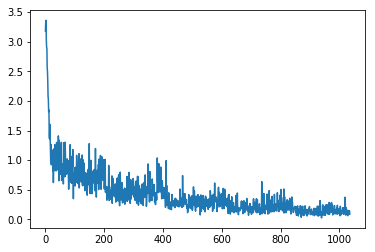

CPU times: user 16min 28s, sys: 2min 22s, total: 18min 50s
Wall time: 16min 10s


In [17]:
%time arya_train()
torch.save(resnet18.state_dict(), 'resnet18.pkl')

In [66]:
resnet18.load_state_dict(torch.load('resnet18.pkl'))
def classification_test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    for images, labels, _ in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
        print('Accuracy of the network on the ' + str(total) +' test images: %d %%' % (100 * correct / total))
    
classification_test(resnet18)

Accuracy of the network on the 100 test images: 83 %
Accuracy of the network on the 200 test images: 81 %
Accuracy of the network on the 300 test images: 80 %
Accuracy of the network on the 400 test images: 81 %
Accuracy of the network on the 500 test images: 82 %
Accuracy of the network on the 600 test images: 82 %
Accuracy of the network on the 700 test images: 82 %
Accuracy of the network on the 800 test images: 83 %
Accuracy of the network on the 900 test images: 83 %
Accuracy of the network on the 1000 test images: 84 %
Accuracy of the network on the 1100 test images: 83 %
Accuracy of the network on the 1200 test images: 82 %
Accuracy of the network on the 1300 test images: 82 %
Accuracy of the network on the 1400 test images: 82 %
Accuracy of the network on the 1500 test images: 83 %
Accuracy of the network on the 1600 test images: 83 %
Accuracy of the network on the 1700 test images: 83 %
Accuracy of the network on the 1800 test images: 82 %
Accuracy of the network on the 1900 t

Accuracy of the network on the 15200 test images: 83 %
Accuracy of the network on the 15300 test images: 83 %
Accuracy of the network on the 15400 test images: 83 %
Accuracy of the network on the 15500 test images: 83 %
Accuracy of the network on the 15600 test images: 83 %
Accuracy of the network on the 15700 test images: 83 %
Accuracy of the network on the 15800 test images: 83 %
Accuracy of the network on the 15900 test images: 83 %
Accuracy of the network on the 16000 test images: 82 %
Accuracy of the network on the 16100 test images: 82 %
Accuracy of the network on the 16200 test images: 82 %
Accuracy of the network on the 16300 test images: 82 %
Accuracy of the network on the 16400 test images: 82 %
Accuracy of the network on the 16500 test images: 82 %
Accuracy of the network on the 16600 test images: 82 %
Accuracy of the network on the 16700 test images: 82 %
Accuracy of the network on the 16800 test images: 82 %
Accuracy of the network on the 16900 test images: 82 %
Accuracy o

# Testing and Accuracy Calculation
Jorah then asks a question, how is this a detection task?<br/>
As everybody wonders, Theon Greyjoy suggests a slding window method to test the above trained trained network on the detection task:<br/>
"We take some windows of varying size and aspect ratios", he mumbled, "and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value!". "He is right", says Samwell, "I read a similar approach in the paper -Faster RCNN by Ross Girshick in the library, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide". You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [67]:
def theon_sliding_window(image,aspect_ratio,size,slide_amount):
    # Begin
    windows = []
    labels = []
    threshold = 0
    for x in xrange(0,image.size[0],slide_amount):
        for y in xrange(0,image.size[1],slide_amount):
            box = [x,y,int(x+size*aspect_ratio),y+size]
            crop_img = image.crop(box).convert('RGB')
            crop_img = composed_transform(crop_img)
            images = Variable(crop_img)
            images = images.unsqueeze(0)
            if(use_gpu):
                images = images.cuda()
            output = resnet18(images)
            output = torch.nn.functional.softmax(output)
            prob,label = torch.topk(output.data,1)
#             print (prob[0][0])
#             print (label)
            if prob[0][0] > threshold and label[0][0] != 0:
                windows.append(box)
                labels.append(label)
    return windows,labels

"Wait", says <b>Jon Snow</b>, "The predicted boxes may be too many and we can't deal with all of them. So, I myself will go and apply non_maximum_supression to reduce the number of boxes". You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [68]:
def aegon_targaryen_non_maximum_supression(boxes,labels,threshold = 0.3):
    boxes = np.array(boxes)
    nms_boxes = []
    nms_labels = []
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
#     if boxes.dtype.kind == "i":
#         boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        nms_boxes.append(boxes[i])
        nms_labels.append(labels[i])
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > threshold)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
#     return boxes[pick].astype("int") , labels[pick]
    return nms_boxes , nms_labels

In [71]:
image = PIL.Image.open('/home/deepak/CS698O/Assignments/Assignment2/test/VOCdevkit/VOC2007/JPEGImages/000001.jpg')
windows,labels = theon_sliding_window(image,1.33,128,10)
print (windows,labels)

[[0, 0, 170, 128], [0, 10, 170, 138], [0, 20, 170, 148], [0, 30, 170, 158], [0, 40, 170, 168], [0, 50, 170, 178], [0, 60, 170, 188], [0, 70, 170, 198], [0, 80, 170, 208], [0, 90, 170, 218], [0, 100, 170, 228], [0, 110, 170, 238], [0, 120, 170, 248], [0, 130, 170, 258], [0, 140, 170, 268], [0, 150, 170, 278], [0, 160, 170, 288], [0, 170, 170, 298], [0, 180, 170, 308], [0, 190, 170, 318], [0, 200, 170, 328], [0, 210, 170, 338], [0, 220, 170, 348], [0, 230, 170, 358], [0, 240, 170, 368], [0, 250, 170, 378], [0, 260, 170, 388], [0, 270, 170, 398], [0, 280, 170, 408], [0, 290, 170, 418], [0, 300, 170, 428], [0, 310, 170, 438], [0, 320, 170, 448], [0, 330, 170, 458], [0, 340, 170, 468], [0, 350, 170, 478], [0, 360, 170, 488], [0, 370, 170, 498], [0, 380, 170, 508], [0, 390, 170, 518], [0, 400, 170, 528], [0, 410, 170, 538], [0, 420, 170, 548], [0, 430, 170, 558], [0, 440, 170, 568], [0, 450, 170, 578], [0, 460, 170, 588], [0, 470, 170, 598], [0, 480, 170, 608], [0, 490, 170, 618], [10, 0, 18

[
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of

In [72]:
windows, labels = aegon_targaryen_non_maximum_supression(windows,labels,0.3)
print (windows,labels)

[array([350, 490, 520, 618]), array([190, 490, 360, 618]), array([ 60, 490, 230, 618]), array([270, 430, 440, 558]), array([120, 420, 290, 548]), array([  0, 420, 170, 548]), array([350, 370, 520, 498]), array([210, 360, 380, 488]), array([ 60, 350, 230, 478]), array([290, 300, 460, 428]), array([140, 290, 310, 418]), array([  0, 280, 170, 408]), array([350, 230, 520, 358]), array([220, 230, 390, 358]), array([ 80, 220, 250, 348]), array([280, 160, 450, 288]), array([  0, 160, 170, 288]), array([160, 160, 330, 288]), array([ 80, 100, 250, 228]), array([220,  90, 390, 218]), array([350,  90, 520, 218]), array([  0,  40, 170, 168]), array([140,  30, 310, 158]), array([290,  20, 460, 148])] [
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)

Daenerys, the queen, then orders her army to test out the trained model on the test dataset.

In [41]:
def daenerys_test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    correct = 0
    total = 0
    aspect_ratio = [1,0.75,1.33,0.5]
    size = [224,128,64]
    slide_amount = 10
    boxes = []
    labels = []
    for images, orig_labels, img_whole in test_loader:
        images = Variable(images)
        img_whole = Variable(img_whole)
        
        if(use_gpu):
            images = images.cuda()
            img_whole = img_whole.cuda()
        
        for i in range(len(aspect_ratio)):
            for j in range(len(size)):
                windows, labels = theon_sliding_window(img_whole,aspect_ratio(i),size(j),slide_amount)
                boxes.extend()
                labels.extend()
        boxes, labels = aegon_targaryen_non_maximum_supression(boxes,labels,0.3)
        
        
        

In [42]:
%time daenerys_test(resnet18)

RuntimeError: inconsistent tensor sizes at /pytorch/torch/lib/TH/generic/THTensorMath.c:2709

# Final Showdown
After covering all the steps and passing the accuracy value to the talking crystal, they all pass through to the land of the living, with a wounded Jon Snow armed with the Dragon-axe. After a fierce battle, Jon Snow manages to go face to face with the Night king. Surrounded by battling men and falling bodies, they engage in a ferocious battle, a battle of spear and axe. After a raging fight, Jon manages to sink the axe into the Night king's heart, but not before he gets wounded by the spear. As dead men fall to bones, Daenerys and others rush to his aid, but it is too late. Everyone is in tears as they look towards the man of honour, Jon Snow, lying in Daenerys's arms when he says his last words: "The night has ended. Winter is finally over!"

In [ ]:
print("The night has ended. Winter is finally over!")